In [2]:
import importlib
from random import seed

import src.utils.config as config
importlib.reload(config)

from src.utils.config import load_config

cfg = load_config()
print(cfg.data.n_paths, cfg.train.lr)

C:\Users\Asees\Documents\Project\hybrid-black-scholes-option-pricing-pinn
50000 0.001


## Testing GBM

In [15]:
import importlib
import numpy as np
import src.data.gbm as gbm
importlib.reload(gbm)

from src.data.gbm import GBMParams, simulate_gbm_paths

In [6]:
params = GBMParams(
    s0=cfg.data.s0,
    r=cfg.data.r,
    sigma=cfg.data.sigma,
    t=cfg.data.t,
    n_steps=cfg.data.n_steps,
)
paths = simulate_gbm_paths(params=params, n_paths=cfg.data.n_paths, seed=cfg.data.seed, return_log=False)

print("shape:", paths.shape)              # (n_paths, n_steps+1)
print("first row first 5:", paths[0, :5]) # first few time points of path 0
print("first col unique:", np.unique(paths[:5, 0]))  # should all be s0 for first 5 paths
print("ST sample:", paths[:5, -1])        # terminal prices for 5 paths
print("mean(ST):", paths[:, -1].mean())
print("std(ST):", paths[:, -1].std())

shape: (50000, 253)
first row first 5: [100.         100.39659657  99.10152081 100.05485958 101.25961664]
first col unique: [100.]
ST sample: [ 88.37592723 110.66645157  76.34895339 105.01675911  97.90382084]
mean(ST): 105.15638709461726
std(ST): 21.253930301989026


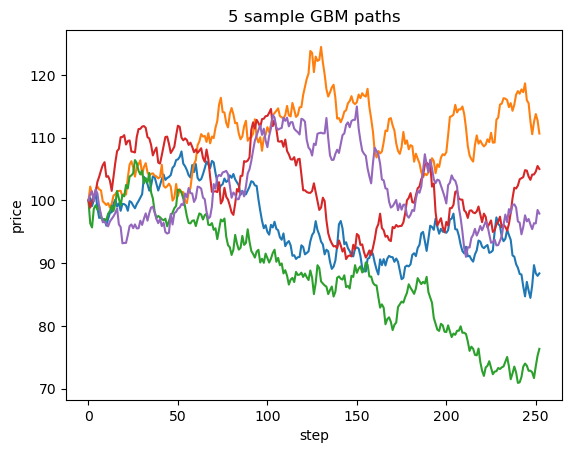

In [7]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.plot(paths[i])
plt.title("5 sample GBM paths")
plt.xlabel("step")
plt.ylabel("price")
plt.show()


### testing make dataset

In [31]:
import importlib
import numpy as np
import src.data.make_mc_dataset as make_mc_dataset
import src.utils.config as config
import src.data.gbm as gbm
import src.data.make_pinn_samples as make_pinn_samples

importlib.reload(make_mc_dataset)
importlib.reload(config)
importlib.reload(gbm)
importlib.reload(make_pinn_samples)

from src.data.make_mc_dataset import payoff_european,mc_price_european
from src.utils.config import load_config
from src.data.gbm import GBMParams

In [23]:
gbm_params = GBMParams(
    s0=cfg.data.s0,
    r=cfg.data.r,
    sigma=cfg.data.sigma,
    t=cfg.data.t,
    n_steps=cfg.data.n_steps,
)

res = mc_price_european(
    gbm_params=gbm_params,
    k=cfg.data.k,
    option_type=cfg.data.option_type,
    n_paths=cfg.data.n_paths,
    seed=cfg.data.seed,
)

print("MC Price: ", res.price)
print("ST Mean: ", res.st.mean(), "ST SD: ", res.st.std())
print("Payoff Mean: ", res.payoff.mean())


MC Price:  10.452616249862382
ST Mean:  105.15638709461726 ST SD:  21.253930301989026
Payoff Mean:  10.988533344990671


In [24]:
# pinn_samples
from src.data.make_pinn_samples import sample_terminal_points

ts = sample_terminal_points(n = 5, t_maturity=1.0, k = 100.0, option_type="call", seed=42)

print("s : ", ts.s)
print("t : ", ts.t)
print("v : ", ts.v)

s :  [[232.18681457]
 [131.66353193]
 [257.57937597]
 [209.21040872]
 [ 28.25320437]]
t :  [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
v :  [[132.18681457]
 [ 31.66353193]
 [157.57937597]
 [109.21040872]
 [  0.        ]]


In [27]:
from src.data.make_pinn_samples import sample_interior_points

ints = sample_interior_points(n = 5, t_maturity=1.0, k = 100.0, seed=42)
print("s : ", ints.s)
print("t : ", ints.t)

s :  [[232.18681402]
 [131.66353205]
 [257.57937526]
 [209.21040832]
 [ 28.25320518]]
t :  [[0.9756214 ]
 [0.76113918]
 [0.78606373]
 [0.12811438]
 [0.45038604]]


In [30]:
from src.data.make_pinn_samples import sample_boundary_points

b = sample_boundary_points(n = 5, t_maturity=1.0, k = 100.0, r=0.05, option_type="call", seed=42)

print("LOW s,t,v: \n", b["low"].s.T, b["low"].t.T, b["low"].v.T)
print("HIGH s,t,v: \n", b["high"].s.T, b["high"].t.T, b["high"].v.T)


LOW s,t,v: 
 [[0. 0. 0. 0. 0.]] [[0.7739555  0.43887856 0.8585972  0.69736763 0.09417816]] [[0. 0. 0. 0. 0.]]
HIGH s,t,v: 
 [[300. 300. 300. 300. 300.]] [[0.7739555  0.43887856 0.8585972  0.69736763 0.09417816]] [[201.12385948 202.76661553 200.70452052 201.50177106 204.42807609]]


In [32]:
from src.data.make_pinn_samples import make_pinn_dataset

pinn = make_pinn_dataset(
    n_terminal=5,
    n_interior=5,
    n_boundary=5,
    t_maturity=1.0,
    k=100.0,
    r=0.05,
    option_type="call",
    seed=42,
)

print(pinn.terminal.s.shape)
print(pinn.interior.s.shape)
print(pinn.boundary["low"].s.shape)
print(pinn.boundary["high"].s.shape)

(5, 1)
(5, 1)
(5, 1)
(5, 1)


In [ ]:
!